# How to use Albumentations for detection tasks if you need to keep all bounding boxes

Some augmentations like `RandomCrop` and `CenterCrop` may transform an image so that it won't contain all original bounding boxes. This example shows how you can use the transform named `RandomSizedBBoxSafeCrop` to crop a part of the image but keep all bounding boxes from the original image.

### Import the required libraries

In [1]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

### Define functions to visualize bounding boxes and class labels on an image

The visualization function is based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

In [2]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

### Get an image and annotations for it

For this example we will use an image from the [COCO dataset](https://cocodataset.org/) that have two associated boduning boxes. The image is available at http://cocodataset.org/#explore?id=386298

#### Load the image from the disk

In [3]:
image = cv2.imread('images/000000386298.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#### Define two bounding boxes with coordinates and class labels

Coordinates for those bounding boxes are declared using the `coco` format. Each bounding box is described using four values `[x_min, y_min, width, height]`. For the detailed description of different formats for bounding boxes coordinates, please refer to the documentation article about bounding boxes - https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/.

In [4]:
bboxes = [[5.66, 138.95, 147.09, 164.88], [366.7, 80.84, 132.8, 181.84]]
category_ids = [17, 18]

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {17: 'cat', 18: 'dog'}

#### Visuaize the image with bounding boxes

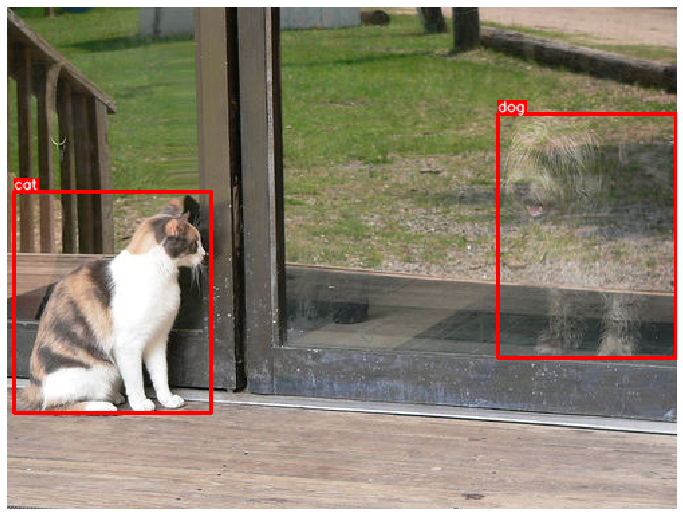

In [5]:
visualize(image, bboxes, category_ids, category_id_to_name)

## Using `RandomSizedBBoxSafeCrop` to keep all bounding boxes from the original image

`RandomSizedBBoxSafeCrop` crops a random part of the image. It ensures that the cropped part will contain all bounding boxes from the original image. Then the transform rescales the crop to height and width specified by the respective parameters. The `erosion_rate` parameter controls how much area of the original bounding box could be lost after cropping. `erosion_rate = 0.2` means that the augmented bounding box's area could be up to 20% smaller than the area of the original bounding box.

### Define an augmentation pipeline

In [6]:
transform = A.Compose(
    [A.RandomSizedBBoxSafeCrop(width=448, height=336, erosion_rate=0.2)],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

### Augment the input image with bounding boxes

We fix the random seed for visualization purposes, so the augmentation will always produce the same result. In a real computer vision pipeline, you shouldn't fix the random seed before applying a transform to the image because, in that case, the pipeline will always output the same image. The purpose of image augmentation is to use different transformations each time.

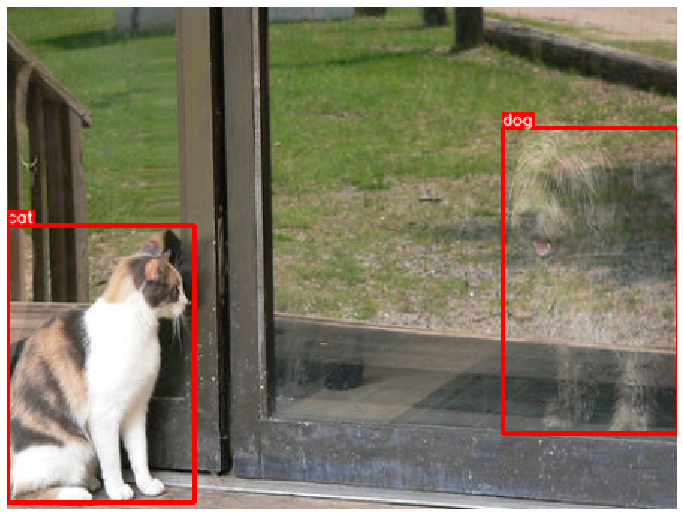

In [7]:
random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

### A few more examples with different random seeds

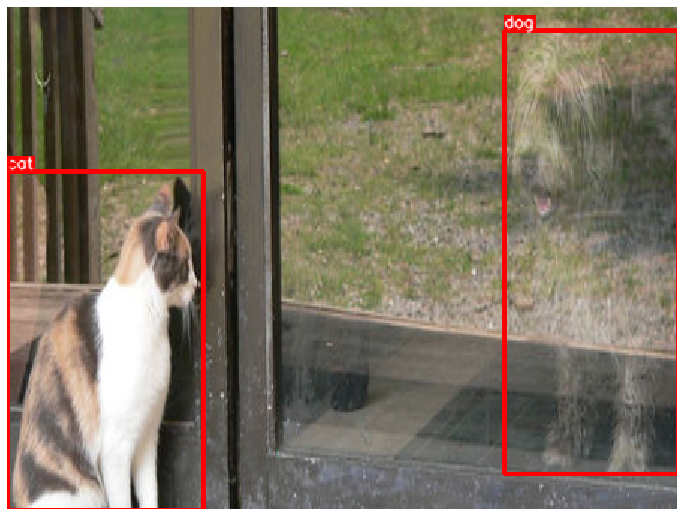

In [8]:
random.seed(3)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

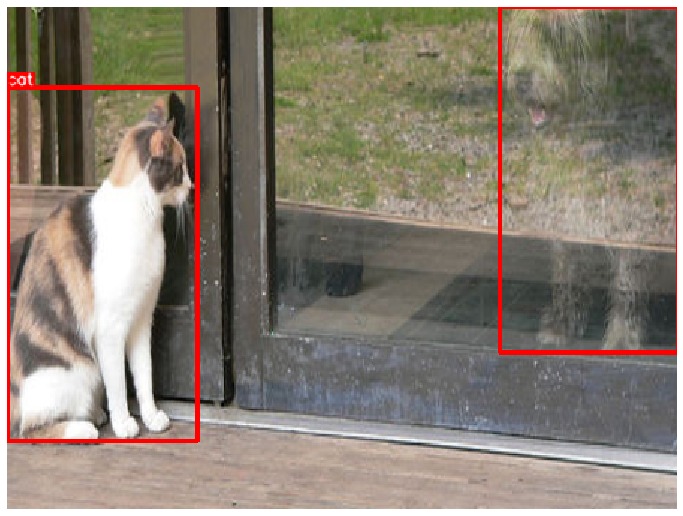

In [9]:
random.seed(444)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)